# Regression model for dry biomasse assessment

In [1]:
# Import required packages
import numpy as np
np.float = float

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.metrics import mean_squared_error


from sklearn import preprocessing
import joblib
import matplotlib.pyplot as plt

### Rangeland sites

In [30]:
## Import input data 
#data_B24 = pd.read_excel("./Model_data.xlsx", sheet_name = "B24 Monthly") # Jachèere##data_BZ26 = pd.read_excel("./Model_data.xlsx", sheet_name = "BZ26 Monthly") # Jachèere
data_K40 = pd.read_excel("./Model_data_completed.xlsx", sheet_name = "K40 Monthly") # Parcours
#data_K6A = pd.read_excel("./Model_data.xlsx", sheet_name = "K6A Monthly") # Jachèere
#data_KA10 = pd.read_excel("./Model_data.xlsx", sheet_name = "KA10 Monthly") # Jachèere
#data_KA18C = pd.read_excel("./Model_data.xlsx", sheet_name = "KA18C Monthly") # Jachèere
data_KA8B = pd.read_excel("./Model_data_completed.xlsx", sheet_name = "KA8B Monthly") # Parcours
data_KB7 = pd.read_excel("./Model_data_completed.xlsx", sheet_name = "KB7 Monthly") # Parcours
data_KK15 = pd.read_excel("./Model_data_completed.xlsx", sheet_name = "KK15 Monthly") # Parcours
#data_KZ7 = pd.read_excel("./Model_data.xlsx", sheet_name = "KZ7 Monthly") # Jachèere
data_TK28 = pd.read_excel("./Model_data_completed.xlsx", sheet_name = "TK28 Monthly") # Parcours
#data_TZ22B = pd.read_excel("./Model_data.xlsx", sheet_name = "TZ22B Monthly") # Jachèere
#
data = pd.concat([data_K40, data_KA8B, data_KB7, data_KK15, data_TK28])
data = data.reset_index()
data = data.iloc[:, 1:22]
data.tail(5)

,date,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,STI,NDTI,DFI,NDRI,Date de mesure,Biomasse (gMS/m2),Biomasse (kg/ha)
35,2022-01-28,1078.213483,1179.842697,1544.779026,2249.632959,2597.861423,2740.344569,2845.636704,2901.940075,2909.382022,4352.498127,2983.415730,0.126623,1.458898,0.186627,24.384520,-0.140221,01/22,28.70,287.0
36,2022-03-29,1457.146067,1598.344569,2038.764045,2823.176030,3157.146067,3293.217228,3409.951311,3537.812734,3490.022472,4921.674157,3592.419476,0.112347,1.370017,0.156124,21.552540,-0.119902,03/22,65.70,657.0
37,2022-05-28,419.220974,540.378277,1086.973783,1997.426966,2415.415730,2548.719101,2685.977528,2596.771536,2823.711610,4796.157303,3251.408240,0.130457,1.475102,0.191952,24.774317,-0.238907,05/22,8.40,84.0
38,2022-10-10,441.513109,673.790262,1162.906367,1800.168539,2297.599251,2827.404494,3089.513109,2939.925094,3128.951311,4211.543071,2901.805243,0.240450,1.451353,0.184124,19.042327,-0.234292,2022-10-05 00:00:00,100.44,1004.4
39,2023-10-20,572.385768,669.591760,1118.382022,1762.730337,2234.378277,2593.898876,2702.700375,2606.880150,2700.558052,4123.056180,2677.235955,0.193187,1.540042,0.212611,23.711545,-0.205971,17/10/23,23.15,231.5


In [31]:
#data = pd.read_excel("./parcours.xlsx")
data.head(2)

,date,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,STI,NDTI,DFI,NDRI,Date de mesure,Biomasse (gMS/m2),Biomasse (kg/ha)
0,2018-11-25,857.123247,1003.681181,1635.597786,2658.839852,2994.291513,3146.185978,3208.977860,3213.756458,3148.088561,4768.813284,3650.064945,0.094493,1.306501,0.132886,19.408917,-0.157115,2018-11-06 00:00:00,283.175,283.175
1,2019-10-01,959.681181,1072.881919,1677.708487,2545.344649,2963.247232,3223.244280,3358.972694,3095.183764,3345.730627,4800.177860,3490.937269,0.097480,1.375040,0.157909,22.429639,-0.156652,2019-10-04 00:00:00,688.075,688.075


In [106]:
# Observed biomass
obs_mass = data["Biomasse (kg/ha)"]
obs_mass.index = data.date
obs_mass.head(1)

date
2018-11-25    283.175
Name: Biomasse (kg/ha), dtype: float64

## Simple LRMs

#### 1. Sites Jachere

#### Model 1:  X = STI

In [32]:
# Define input output data
sti_data = data.iloc[:, [13, 19]]
sti_data.head(2)

,STI,Biomasse (kg/ha)
0,1.306501,283.175
1,1.375040,688.075


In [35]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
RMSE_list = []
mae_list = []
MAPE_list = []
RMSPE_list = []

for i in range(0, len(sti_data)):
    X = sti_data[["STI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_data[["STI"]]
    y = sti_data["Biomasse (kg/ha)"]  
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, model_1.predict(X), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  model_1.predict(X))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - model_1.predict(X)))/y.values)
    MAPE_list.append(mape)
    rmspe = rmspe = (np.sqrt(np.mean(np.square((y.values - model_1.predict(X)) / y.values)))) * 100
    RMSPE_list.append(rmspe)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list, "RMSPE": RMSPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]        

,coef,cste,R2,RMSE,mae,MAPE,RMSPE
22,[954.1674556951766],-776.034337,0.089963,351.086707,268.972839,1.264499,236.608095


In [6]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[6]
model_1.intercept_ = reg_results.cste.values[6]

In [8]:
# Save the regression model
#joblib.dump(model_1, "./model 1/model_B24.pkl") 

#### 2. Model 2:  X = NDTI

In [36]:
# Define input output data
ndti_data = data.iloc[:, [14, 19]]
ndti_data.head(2)

,NDTI,Biomasse (kg/ha)
0,0.132886,283.175
1,0.157909,688.075


In [38]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(ndti_data)):
    X = ndti_data[["NDTI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = ndti_data[["NDTI"]]
    y = ndti_data["Biomasse (kg/ha)"]     
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
22,[2662.0317860829764],123.449786,0.094163,350.275587,267.840405,-98.995617


In [39]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[10]
model_1.intercept_ = reg_results.cste.values[10]

In [40]:
# Save the regression model
#joblib.dump(model_1, "./model 2/model_B24.pkl") 

#### 3. Model 3:  X = DFI

In [41]:
# Define input output data
dfi_data = data.iloc[:, [15, 19]]
dfi_data.head(2)

,DFI,Biomasse (kg/ha)
0,19.408917,283.175
1,22.429639,688.075


In [42]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(dfi_data)):
    X = dfi_data[["DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = dfi_data[["DFI"]]
    y = dfi_data["Biomasse (kg/ha)"]   
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
34,[-2.1287363842519307],484.641923,0.000682,367.905959,296.954691,-104.522888


In [15]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[10]
model_1.intercept_ = reg_results.cste.values[10]

In [16]:
# Save the regression model
#joblib.dump(model_1, "./model 3/model_B24.pkl") 

#### 4. Model 4:  X = NDRI

In [43]:
# Define input output data
ndri_data = data.iloc[:, [16, 19]]
ndri_data.head(2)

,NDRI,Biomasse (kg/ha)
0,-0.157115,283.175
1,-0.156652,688.075


In [45]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(ndri_data)):
    X = ndri_data[["NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = ndri_data[["NDRI"]]
    y = ndri_data["Biomasse (kg/ha)"]    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
3,[-4364.123314373005],-387.642091,0.401222,284.785366,212.231134,-74.328977


In [46]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[3]
model_1.intercept_ = reg_results.cste.values[3]

In [49]:
# Save the regression model
#joblib.dump(model_1, "./model 4/model_B24.pkl") 

#### 5. Model 5:  X = [STI, NDTI]

In [50]:
# Define input output data
sti_ndti_data = data.iloc[:, [13,14,19]]
sti_ndti_data.head(2)

,STI,NDTI,Biomasse (kg/ha)
0,1.306501,0.132886,283.175
1,1.375040,0.157909,688.075


In [51]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(sti_ndti_data)):
    X = sti_ndti_data[["STI", "NDTI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_ndti_data[["STI", "NDTI"]]
    y = sti_ndti_data["Biomasse (kg/ha)"]    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
23,"[-10998.414457510931, 32568.1285520314]",10589.31231,0.116572,345.915929,271.743138,-102.489254


In [52]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[10]
model_1.intercept_ = reg_results.cste.values[10]

In [53]:
# Save the regression model
#joblib.dump(model_1, "./model 5/model_B24.pkl") 

#### 6. Model 6:  X = [STI, DFI]

In [54]:
# Define input output data
sti_dfi_data = data.iloc[:, [13,15,19]]
sti_dfi_data.head(2)

,STI,DFI,Biomasse (kg/ha)
0,1.306501,19.408917,283.175
1,1.375040,22.429639,688.075


In [59]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(sti_dfi_data)):
    X = sti_dfi_data[["STI", "DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_dfi_data[["STI", "DFI"]]
    y = sti_dfi_data["Biomasse (kg/ha)"]      
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
33,"[4971.4999891914595, -115.07439676253975]",-4081.038975,0.503679,259.278461,193.188309,-45.00385


In [60]:
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[33]
model_1.intercept_ = reg_results.cste.values[33]

In [61]:
# Save the regression model
#joblib.dump(model_1, "./model 6/model_B24.pkl") 

#### 7. Model 7:  X = [STI, NDRI]

In [62]:
# Define input output data
sti_ndri_data = data.iloc[:, [13,16,19]]
sti_ndri_data.head(2)

,STI,NDRI,Biomasse (kg/ha)
0,1.306501,-0.157115,283.175
1,1.375040,-0.156652,688.075


In [64]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(sti_ndri_data)):
    X = sti_ndri_data[["STI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_ndri_data[["STI", "NDRI"]]
    y = sti_ndri_data["Biomasse (kg/ha)"]     
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()] 

,coef,cste,R2,RMSE,mae,MAPE
16,"[842.5891311707312, -4258.29884165223]",-1450.930942,0.47061,267.776737,188.451272,-69.356018


In [ ]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[16]
model_1.intercept_ = reg_results.cste.values[16]

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 7/model_B24.pkl") 

#### 8. Model 8:  X = [NDTI, DFI]

In [65]:
# Define input output data
ndti_dfi_data = data.iloc[:, [14,15,19]]
ndti_dfi_data.head(2)

,NDTI,DFI,Biomasse (kg/ha)
0,0.132886,19.408917,283.175
1,0.157909,22.429639,688.075


In [68]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(ndti_dfi_data)):
    X = ndti_dfi_data[["NDTI", "DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = ndti_dfi_data[["NDTI", "DFI"]]
    y = ndti_dfi_data["Biomasse (kg/ha)"]   
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]   

,coef,cste,R2,RMSE,mae,MAPE
24,"[14498.114185465218, -124.06750246245565]",674.787748,0.55305,246.044849,178.709425,-42.221232


In [69]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[24]
model_1.intercept_ = reg_results.cste.values[24]

In [70]:
# Save the regression model
#joblib.dump(model_1, "./model 8/model_B24.pkl") 

#### 9. Model 9:  X = [NDTI, NDRI]

In [71]:
# Define input output data
ndti_ndri_data = data.iloc[:, [14,16,19]]
ndti_ndri_data.head(2)

,NDTI,NDRI,Biomasse (kg/ha)
0,0.132886,-0.157115,283.175
1,0.157909,-0.156652,688.075


In [73]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(ndti_ndri_data)):
    X = ndti_ndri_data[["NDTI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = ndti_ndri_data[["NDTI", "NDRI"]]
    y = ndti_ndri_data["Biomasse (kg/ha)"]    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]  

,coef,cste,R2,RMSE,mae,MAPE
16,"[2341.0165962575134, -4252.317121349747]",-654.093319,0.473577,267.025347,187.261927,-69.564283


In [ ]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[10]
model_1.intercept_ = reg_results.cste.values[10]

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 9/model_B24.pkl") 

#### 10. Model 10:  X = [DFI, NDRI]

In [74]:
# Define input output data
dfi_ndri_data = data.iloc[:, [15,16,19]]
dfi_ndri_data.head(2)

,DFI,NDRI,Biomasse (kg/ha)
0,19.408917,-0.157115,283.175
1,22.429639,-0.156652,688.075


In [76]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(dfi_ndri_data)):
    X = dfi_ndri_data[["DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = dfi_ndri_data[["DFI", "NDRI"]]
    y = dfi_ndri_data["Biomasse (kg/ha)"]    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()] 

,coef,cste,R2,RMSE,mae,MAPE
17,"[13.886864778327155, -4698.230541469566]",-676.564364,0.427841,278.383372,200.988978,-75.133131


In [77]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[17]
model_1.intercept_ = reg_results.cste.values[17]

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 10/model_B24.pkl") 

#### 11. Model 11:  X = [STI, NDTI, DFI]

In [82]:
# Define input output data
sti_ndti_dfi_data = data.iloc[:, [13, 14, 15,19]]
sti_ndti_dfi_data.head(2)

,STI,NDTI,DFI,Biomasse (kg/ha)
0,1.306501,0.132886,19.408917,283.175
1,1.375040,0.157909,22.429639,688.075


In [84]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(sti_ndti_dfi_data)):
    X = sti_ndti_dfi_data[["STI", "NDTI", "DFI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_dfi_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_ndti_dfi_data[["STI", "NDTI", "DFI"]]
    y = sti_ndti_dfi_data["Biomasse (kg/ha)"]   
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]      

,coef,cste,R2,RMSE,mae,MAPE
16,"[-24297.705846224813, 81973.23558145386, -139....",23872.128651,0.659643,214.709931,159.382395,-44.014352


In [85]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[16]
model_1.intercept_ = reg_results.cste.values[16]

In [86]:
model_1.coef_

array([-24297.70584622,  81973.23558145,   -139.34012176])

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 11/model_B24.pkl") 

#### 12. Model 12:  X = [STI, NDTI, NDRI]

In [91]:
# Define input output data
sti_ndti_ndri_data = data.iloc[:, [13, 14, 16,19]]
sti_ndti_ndri_data.head(2)

,STI,NDTI,NDRI,Biomasse (kg/ha)
0,1.306501,0.132886,-0.157115,283.175
1,1.375040,0.157909,-0.156652,688.075


In [92]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(sti_ndti_ndri_data)):
    X = sti_ndti_ndri_data[["STI","NDTI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_ndti_ndri_data[["STI","NDTI", "NDRI"]]
    y = sti_ndti_ndri_data["Biomasse (kg/ha)"]   
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]          

,coef,cste,R2,RMSE,mae,MAPE
3,"[-8695.56401509066, 25966.969821158295, -4210....",7631.690703,0.487989,263.344776,183.337914,-73.136222


In [93]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[3]
model_1.intercept_ = reg_results.cste.values[3]

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 12/model_B24.pkl") 

#### 13. Model 13:  X = [STI, DFI, NDRI]

In [94]:
# Define input output data
sti_dfi_ndri_data = data.iloc[:, [13, 15, 16,19]]
sti_dfi_ndri_data.head(2)

,STI,DFI,NDRI,Biomasse (kg/ha)
0,1.306501,19.408917,-0.157115,283.175
1,1.375040,22.429639,-0.156652,688.075


In [95]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []

for i in range(0, len(sti_dfi_ndri_data)):
    X = sti_dfi_ndri_data[["STI","DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = sti_dfi_ndri_data[["STI","DFI", "NDRI"]]
    y = sti_dfi_ndri_data["Biomasse (kg/ha)"]     
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]         

,coef,cste,R2,RMSE,mae,MAPE
16,"[3469.020174176503, -73.75167034147259, -2129....",-3226.455088,0.545812,248.029184,175.166391,-49.625178


In [96]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[10]
model_1.intercept_ = reg_results.cste.values[10]

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 13/model_B24.pkl") 

#### 14. Model 14:  X = [NDTI, DFI, NDRI]

In [97]:
# Define input output data
ndti_dfi_ndri_data = data.iloc[:, [14, 15, 16,19]]
ndti_dfi_ndri_data.head(2)

,NDTI,DFI,NDRI,Biomasse (kg/ha)
0,0.132886,19.408917,-0.157115,283.175
1,0.157909,22.429639,-0.156652,688.075


In [99]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []


for i in range(0, len(ndti_dfi_ndri_data)):
    X = ndti_dfi_ndri_data[["NDTI","DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = ndti_dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    X = ndti_dfi_ndri_data[["NDTI","DFI", "NDRI"]]
    y = ndti_dfi_ndri_data["Biomasse (kg/ha)"]    
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, (model_1.predict(X)), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  (model_1.predict(X)))
    mae_list.append(mae)
    mape = np.mean((y.values - (model_1.predict(X)))/y.values)*100
    MAPE_list.append(mape)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]           

,coef,cste,R2,RMSE,mae,MAPE
16,"[11275.45773198697, -91.56828176465764, -1591....",239.830882,0.574597,240.040909,169.330638,-46.161938


In [100]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[16]
model_1.intercept_ = reg_results.cste.values[16]

In [ ]:
# Save the regression model
#joblib.dump(model_1, "./model 14/model_B24.pkl") 

#### 15. Model 15:  X = [STI, NDTI, DFI, NDRI]

In [132]:
# Define input output data
sti_ndti_dfi_ndri_data = data.iloc[:, [13, 14, 15, 16,19]]
sti_ndti_dfi_ndri_data.head(2)

,STI,NDTI,DFI,NDRI,Biomasse (kg/ha)
0,1.306501,0.132886,19.408917,-0.157115,283.175
1,1.375040,0.157909,22.429639,-0.156652,688.075


In [133]:
# Define predictor and response variables
coef_list = []
cste_list = []
R2_list = []
mae_list = []
RMSE_list = []
MAPE_list = []
RMSPE_list = []
for i in range(0, len(sti_ndti_dfi_ndri_data)):
    X = sti_ndti_dfi_ndri_data[["STI","NDTI","DFI", "NDRI"]]
    var_out = X.index.isin([i])
    X = X.loc[~var_out]         # Leave one out
    
    y = sti_ndti_dfi_ndri_data["Biomasse (kg/ha)"][X.index] # same indices as X
    
    model_1 = LinearRegression().fit(X, y)
    
    coef = model_1.coef_
    coef_list.append(coef)
    
    cste =  model_1.intercept_
    cste_list.append(cste)
    
    X = sti_ndti_dfi_ndri_data[["STI","NDTI","DFI", "NDRI"]]
    y = sti_ndti_dfi_ndri_data["Biomasse (kg/ha)"] 
    R2 = r2_score(y.values,  (model_1.predict(X)))
    R2_list.append(R2)
    RMSE = mean_squared_error(y.values, model_1.predict(X), squared=False)
    RMSE_list.append(RMSE)
    mae = mean_absolute_error(y.values,  model_1.predict(X))
    mae_list.append(mae)
    mape = np.mean(np.abs((y.values - model_1.predict(X))/y.values))*100
    MAPE_list.append(mape)
    rmspe = rmspe = (np.sqrt(np.mean(np.square((y.values - model_1.predict(X)) / y.values)))) * 100
    RMSPE_list.append(rmspe)
    
result_dic = {"coef" : coef_list, "cste": cste_list, "R2" : R2_list,"RMSE": RMSE_list, "mae": mae_list, "MAPE": MAPE_list, "RMSPE": RMSPE_list}    
reg_results = pd.DataFrame(result_dic)
reg_results.loc[reg_results.RMSE == reg_results.RMSE.min()]         

,coef,cste,R2,RMSE,mae,MAPE,RMSPE
16,"[-23606.022992506063, 79523.87921568174, -133....",23140.012296,0.660145,214.551569,157.792545,67.681262,114.795907


In [134]:
# Predict the out var using the best model
model_1 = LinearRegression()
model_1.coef_ = reg_results.coef.values[16]
model_1.intercept_ = reg_results.cste.values[16]

In [135]:
model_1.coef_

array([-23606.02299251,  79523.87921568,   -133.56162732,   -261.55073492])

### Plot the results

In [136]:
X = sti_ndti_dfi_ndri_data[["STI","NDTI","DFI", "NDRI"]]
y = sti_ndti_dfi_ndri_data["Biomasse (kg/ha)"]
y_predicted = (model_1.predict(X))

C:\Users\GARBA\anaconda3\envs\geo_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


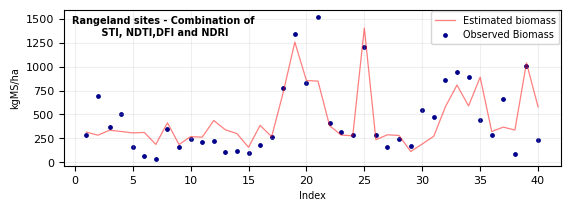

In [137]:
fig, ax = plt.subplots(1, 1, figsize = (5.6,2.), constrained_layout = True)
ax.scatter(range(1, 41, 1), obs_mass.values, label = "Observed Biomass", color = "darkblue", s = 6)
ax.plot(range(1, 41, 1),y_predicted, lw = .9, label = "Estimated biomass", color = "r", alpha = .5)
#ax.set_xticks(sti_data.index)
#ax.set_yticks(np.arange(0, 1500, 200))
ax.set_ylabel("kgMS/ha", fontsize = 7)
ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7, loc = (0.74, 0.78))
ax.set_title("Rangeland sites - Combination of\n STI, NDTI,DFI and NDRI", fontsize = 7, fontweight = "bold", x = 0.2, y = .78)
ax.grid("both", alpha = 0.2)
plt.savefig("./output/model_15.png", dpi = 600)

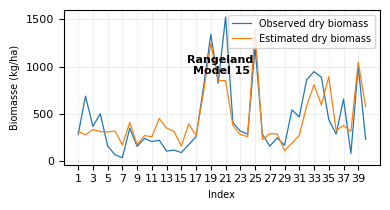

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (4,2.2))
ax.plot(np.arange(1, 41, 1), y, lw = .9, label = "Observed dry biomass")
ax.plot(np.arange(1, 41, 1), y_predicted, lw = .9, label = "Estimated dry biomass")

ax.set_xticks(np.arange(1, 41, 2))
#ax.set_yticks(np.arange(0, 9000, 1000))
ax.set_ylabel("Biomasse (kg/ha)", fontsize = 7)
ax.set_xlabel("Index",  fontsize = 7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(fontsize = 7)
ax.set_title("Rangeland \nModel 15", fontsize = 8, fontweight = "bold", x = 0.5, y = .53)
ax.grid("both", alpha = 0.2)
plt.tight_layout()
plt.savefig("./model_15_parcours.png", dpi = 600)